<a href="https://colab.research.google.com/github/mr1er0y/VK_Topic_modeling/blob/main/lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [ ]:
import os
import sys
# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn

# Libraries and packages for text (pre-)processing
import string
import re
import nltk


path = "/content/drive/MyDrive/Data_VK/VK_MOSCOW_Posts.csv"

# Чтение данных

In [ ]:
df = pd.read_csv(path, sep=';')
df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text
0,VK_-197953208_1105,https://vk.com/wall-197953208_1105,2023-02-27T06:46:51Z,VK_-197953208,VK_-197953208,1,0,0,0,0,Состав команды:\n1. Дубовский Иван (lllKORNlll...
1,VK_134219584_2687,https://vk.com/wall134219584_2687,2023-03-04T15:52:56Z,VK_134219584,VK_134219584,1,0,0,1,79,NaN
2,VK_8036_3391,https://vk.com/wall8036_3391,2023-03-07T10:11:00Z,VK_8036,VK_8036,1,0,25,0,637,Сегодня о серьезном. Как отличить правду от фе...
3,VK_8036_3389,https://vk.com/wall8036_3389,2023-03-05T18:44:02Z,VK_8036,VK_8036,1,0,18,0,317,"Классный день, классные люди, классное занятие:)"
4,VK_8036_3387,https://vk.com/wall8036_3387,2023-03-04T14:26:04Z,VK_8036,VK_8036,1,0,22,0,201,NaN


In [ ]:
df = df[df["Text"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1366579 entries, 0 to 1447758
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ID            1366579 non-null  object
 1   URL           1366579 non-null  object
 2   CreatedDate   1366579 non-null  object
 3   AuthorID      1366579 non-null  object
 4   OwnerID       1366579 non-null  object
 5   PostType      1366579 non-null  int64 
 6   CommentCount  1366579 non-null  int64 
 7   LikeCount     1366579 non-null  int64 
 8   ShareCount    1366579 non-null  int64 
 9   ViewsCount    1366579 non-null  int64 
 10  Text          1366579 non-null  object
dtypes: int64(5), object(6)
memory usage: 125.1+ MB


Давайте посмотрим отношение между комметариями и постами

1 - это посты в социальной сети VK

2 - это комментарии к постам



In [ ]:
df["PostType"].value_counts().to_frame("num")

,num
2,1136530
1,230049


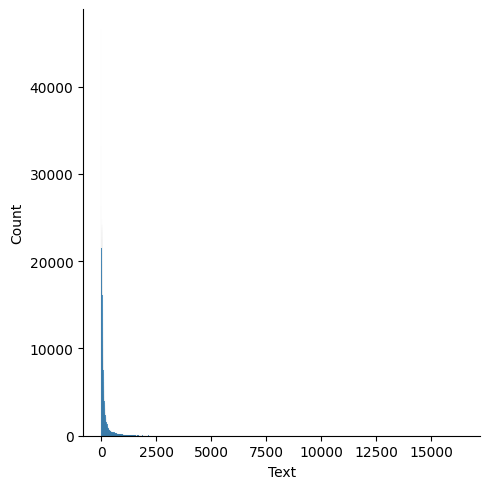

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df["Text"].apply(lambda x: len(x)), kde=False)

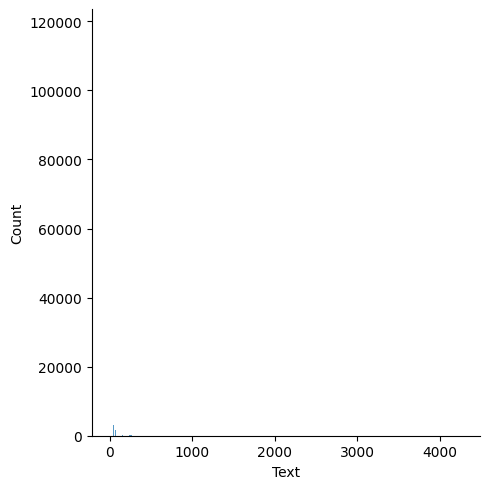

In [ ]:
sns.displot(df["Text"].apply(lambda x: len(x.split())), kde=False)

In [ ]:
df = df[df["PostType"] == 1]
df["Text"].to_frame()

,Text
0,Состав команды:\n1. Дубовский Иван (lllKORNlll...
2,Сегодня о серьезном. Как отличить правду от фе...
3,"Классный день, классные люди, классное занятие:)"
5,"Просто будь собой. Легко сказать. Признайтесь,..."
6,Сегодня вся лента пестрит весной. Если бы мони...
...,...
1447753,"Продам Форд Мондео на ходу, автомат поломан ед..."
1447754,"Продам ВАЗ 2110, 2002 года, хорошая комплектац..."
1447756,"Ездить можно по закону, но не переоформить,\nР..."
1447757,ВАЗ 2106 \nЮр чистая\nНе гнилая \nНа ходу \n43...


In [ ]:
df = df[df["Text"].apply(lambda x: len(x.split())) < 400]
df =  df[df["Text"].apply(lambda x: len(x.split())) > 6]

In [ ]:
df = df.sample(2000)

# Text Cleaning Tasks

### Capitalization/ Приведение текста к нижнему регистру

In [ ]:
df["text_clean"] = df["Text"].apply(lambda x: x.lower())

In [ ]:
def remove_e(text):
    """
        Change Ёё  to е from a sample string
    """
    return  re.sub('[Ёё]', 'е',  text)

In [ ]:
df["text_clean"] = df["text_clean"].apply(lambda x: remove_e(x))

### Удаление URLs

In [ ]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [ ]:
# remove urls from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_URL(x))

### Удаление HTML tags

In [ ]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [ ]:
# remove html from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_html(x))

In [ ]:
df.head(5)

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,text_clean
1317601,VK_-62494679_44251,https://vk.com/wall-62494679_44251,2023-03-12T15:15:00Z,VK_-62494679,VK_-62494679,1,0,4,2,8108,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...","ищу 5 «зеленых» дизайнеров, которые бесплатно ..."
127340,VK_-74998389_71230,https://vk.com/wall-74998389_71230,2023-03-14T14:06:56Z,VK_-74998389,VK_-74998389,1,0,1,0,538,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от 10 до 25 тысяч ко дн...
338931,VK_-163784141_247742,https://vk.com/wall-163784141_247742,2023-03-17T16:37:00Z,VK_-163784141,VK_-163784141,1,0,11,3,1818,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички 👁 👁 стоимо...
11286,VK_-34116496_194926,https://vk.com/wall-34116496_194926,2023-03-23T06:04:00Z,VK_-34116496,VK_-34116496,1,0,3,1,2171,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий smm-менеджер в topcareer (удаленка). \...
756100,VK_-197809640_6493,https://vk.com/wall-197809640_6493,2023-03-03T18:14:07Z,VK_-197809640,VK_-197809640,1,0,0,0,354,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр-371 стоимо...


### Удаление Non-ASCI:

In [ ]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

In [ ]:
# remove non-ascii characters from the text
# df["text_clean"] = df["text_clean"].apply(lambda x: remove_non_ascii(x))

### Удаление обращений

In [ ]:
def remove_id(text):
    """
        Remove id characters
    """
    return re.sub(r'\[.*?\]', '', text)

In [ ]:
df["text_clean"] = df["text_clean"].apply(lambda x: remove_id(x))

### Удаление пунктуации

In [ ]:
def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", text)
    # return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# remove punctuations from the text
df["text_clean"] = df["text_clean"].apply(lambda x: remove_punct(x))

### Удаление non-rus_eng

In [ ]:
def remove_non_rus_eng(text):
    """
        Remove non-rus_eng characters
    """
    return re.sub(r'[^а-яА-Я ]', r' ', text)
    # return re.sub(r'[^a-zA-Zа-яА-Я0-9 ]', r' ', text)

In [ ]:
df["text_clean"] = df["text_clean"].apply(lambda x: remove_non_rus_eng(x))

In [ ]:
# Удаляем все строки, где текст отсутствует
df = df[df["Text"].str.strip() != ""]

In [ ]:
df[df["PostType"] == 1][["Text", "text_clean"]].head(20)

,Text,text_clean
1317601,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...",ищу зеленых дизайнеров которые бесплатно ...
127340,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...
338931,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички стоимо...
11286,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий менеджер в удаленка ...
756100,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр стоимо...
109564,"Фестивальная ул., д. 24 и т. н\n\n#ретро_Ховрино",фестивальная ул д и т н ретро ховрино
776961,Сайт для бренда премиум-украшений \n \nПрезент...,сайт для бренда премиум украшений презентац...
652878,Найдена карта возле суда.\nПисать в личку.,найдена карта возле суда писать в личку
65378,[id8116857|Ирина Моисеева] планирует купить на...,планирует купить на вешняковской к кварти...
1328110,«Владимир Кобрин. Острова» (2001)\n\nТворчеств...,владимир кобрин острова творчество ...


### Spelling correction

In [ ]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.5 MB/s eta 0:00:00


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker(language='ru')  # use the Russian Dictionary

# correction(word) # Returns the most probable result for the misspelled word

misspelled = spell.unknown("1 мapтa βceмиpный дeнь кoшeк".split())

for word in misspelled:
    # Get the one `most likely` answer
    print(word, spell.correction(word))

кoшeк кошек
дeнь день
βceмиpный None
мapтa None


In [ ]:
# нужно удалить дубликаты и пустые строчки
df[df.duplicated("text_clean", keep=False)][["Text", "text_clean"]]

,Text,text_clean
127340,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...
118523,"""Московскому долголетию"" 5 лет! Мэр сказал, чт...",московскому долголетию лет мэр сказал чт...
1202145,"РЦ ""ЗООДОМ"" Королев, МО. \n\nДорогие наши друз...",рц зоодом королев мо дорогие наши друзья...
468370,МОСКВА И МО \nТрогательную котёнку Алису ждёт ...,москва и мо трогательную котенку алису ждет у...
162170,"""Московскому долголетию"" 5 лет! Мэр сказал, чт...",московскому долголетию лет мэр сказал чт...
705978,Санкт-Петербург \n \n🏡Котик Локи ищет дом!🏡 \n...,санкт петербург котик локи ищет дом сде...
1098118,https://music.apple.com/ru/artist/igor-butorin...,
259672,Просвещение начинается с тебя!\n\nКаждый учите...,просвещение начинается с тебя каждый учитель...
14969,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...
49377,Как бороться с курильщиками бросающими бычки и...,как бороться с курильщиками бросающими бычки и...


In [ ]:
df = df.drop_duplicates("text_clean")
df = df[df["text_clean"].apply(lambda x: len(x)) > 30]

# Text Preprocessing

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize

df['tokenized'] = df['text_clean'].apply(word_tokenize)
df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,text_clean,tokenized
1317601,VK_-62494679_44251,https://vk.com/wall-62494679_44251,2023-03-12T15:15:00Z,VK_-62494679,VK_-62494679,1,0,4,2,8108,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...",ищу зеленых дизайнеров которые бесплатно ...,"[ищу, зеленых, дизайнеров, которые, бесплатно,..."
127340,VK_-74998389_71230,https://vk.com/wall-74998389_71230,2023-03-14T14:06:56Z,VK_-74998389,VK_-74998389,1,0,1,0,538,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...,"[мэр, выплатит, ветеранам, от, до, тысяч, ко, ..."
338931,VK_-163784141_247742,https://vk.com/wall-163784141_247742,2023-03-17T16:37:00Z,VK_-163784141,VK_-163784141,1,0,11,3,1818,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички стоимо...,"[срочно, требуются, модели, на, реснички, стои..."
11286,VK_-34116496_194926,https://vk.com/wall-34116496_194926,2023-03-23T06:04:00Z,VK_-34116496,VK_-34116496,1,0,3,1,2171,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий менеджер в удаленка ...,"[ведущий, менеджер, в, удаленка, привет, мы, п..."
756100,VK_-197809640_6493,https://vk.com/wall-197809640_6493,2023-03-03T18:14:07Z,VK_-197809640,VK_-197809640,1,0,0,0,354,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр стоимо...,"[продам, новый, сигнальный, пистолет, мр, стои..."


## Удаление стоп слов

Стоп-слова - это распространенные слова в любом языке, которые встречаются с высокой частотой, но не несут значимой информации для всего предложени

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Получение списка русских стоп-слов из NLTK
stop_words = set(stopwords.words('russian'))

# Предварительная обработка текста
df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df[["Text", "text_clean", "tokenized", "stopwords_removed"]].head()

,Text,text_clean,tokenized,stopwords_removed
1317601,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...",ищу зеленых дизайнеров которые бесплатно ...,"[ищу, зеленых, дизайнеров, которые, бесплатно,...","[ищу, зеленых, дизайнеров, которые, бесплатно,..."
127340,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...,"[мэр, выплатит, ветеранам, от, до, тысяч, ко, ...","[мэр, выплатит, ветеранам, тысяч, ко, дню, поб..."
338931,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички стоимо...,"[срочно, требуются, модели, на, реснички, стои...","[срочно, требуются, модели, реснички, стоимост..."
11286,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий менеджер в удаленка ...,"[ведущий, менеджер, в, удаленка, привет, мы, п...","[ведущий, менеджер, удаленка, привет, проект, ..."
756100,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр стоимо...,"[продам, новый, сигнальный, пистолет, мр, стои...","[продам, новый, сигнальный, пистолет, мр, стои..."




## Stemming

Stemming - это процесс выделения корневого слова - определения общей основы среди различных форм (например, единственного и множественного числа существительных) слова, например, слова "садоводство", "садовник" или "садик" имеют одну и ту же основу, сад. Выделение суффиксов с корнем из слов позволяет объединить слова со схожими значениями в рамках их стандартной основы.

### SnowballStemmer

In [ ]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("russian")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [ ]:
df['snowball_stemmer'] = df['stopwords_removed'].apply(lambda x: " ".join(snowball_stemmer(x)))

df.head()

,ID,URL,CreatedDate,AuthorID,OwnerID,PostType,CommentCount,LikeCount,ShareCount,ViewsCount,Text,text_clean,tokenized,stopwords_removed,snowball_stemmer
1317601,VK_-62494679_44251,https://vk.com/wall-62494679_44251,2023-03-12T15:15:00Z,VK_-62494679,VK_-62494679,1,0,4,2,8108,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...",ищу зеленых дизайнеров которые бесплатно ...,"[ищу, зеленых, дизайнеров, которые, бесплатно,...","[ищу, зеленых, дизайнеров, которые, бесплатно,...",ищ зелен дизайнер котор бесплатн пройдут интен...
127340,VK_-74998389_71230,https://vk.com/wall-74998389_71230,2023-03-14T14:06:56Z,VK_-74998389,VK_-74998389,1,0,1,0,538,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...,"[мэр, выплатит, ветеранам, от, до, тысяч, ко, ...","[мэр, выплатит, ветеранам, тысяч, ко, дню, поб...",мэр выплат ветеран тысяч ко дню побед помощ по...
338931,VK_-163784141_247742,https://vk.com/wall-163784141_247742,2023-03-17T16:37:00Z,VK_-163784141,VK_-163784141,1,0,11,3,1818,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички стоимо...,"[срочно, требуются, модели, на, реснички, стои...","[срочно, требуются, модели, реснички, стоимост...",срочн треб модел ресничк стоимост комплекс мет...
11286,VK_-34116496_194926,https://vk.com/wall-34116496_194926,2023-03-23T06:04:00Z,VK_-34116496,VK_-34116496,1,0,3,1,2171,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий менеджер в удаленка ...,"[ведущий, менеджер, в, удаленка, привет, мы, п...","[ведущий, менеджер, удаленка, привет, проект, ...",ведущ менеджер удаленк привет проект котор пом...
756100,VK_-197809640_6493,https://vk.com/wall-197809640_6493,2023-03-03T18:14:07Z,VK_-197809640,VK_-197809640,1,0,0,0,354,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр стоимо...,"[продам, новый, сигнальный, пистолет, мр, стои...","[продам, новый, сигнальный, пистолет, мр, стои...",прод нов сигнальн пистолет мр стоимост рубл го...


## Лемматизация

In [ ]:
from pymystem3 import Mystem
mystem = Mystem()

def lemmatize_text(text):
    lemmas = mystem.lemmatize( ' '.join(text))
    return ''.join(lemmas).strip()

# Example usage
text = "Я люблю программирование".split()
lemmatized_text = lemmatize_text(text)
print(lemmatized_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


я любить программирование


In [ ]:
df['lemmatize_word_wo_pos'] = df['stopwords_removed'].apply(lambda x: lemmatize_text(x))

In [ ]:
df['lemmatize_word_wo_pos']

1317601    искать зеленый дизайнер который бесплатно прох...
127340     мэр выплачивать ветеран тысяча ко день победа ...
338931     срочно требоваться модель ресничка стоимость к...
11286      ведущий менеджер удаленка привет проект которы...
756100     продавать новый сигнальный пистолет мр стоимос...
                                 ...                        
934219     паровоз ущелие самый необычный железный дорога...
190107     египет шарм эль шейх вылет апрель день москва ...
979078     продавать сарафан ручной вышивка карман хлопок...
514241     ввод жилье москва январь февраль год мосстат юзао
272624     привет друг хотеть узнавать какой услуга наибо...
Name: lemmatize_word_wo_pos, Length: 1985, dtype: object

# Тест №1 (Dostoevsky)
За основу был взят [код](https://leftjoin.ru/all/constitution-sentiment-analysis/)

In [ ]:
# !pip install dostoevsky
# !python -m dostoevsky download fasttext-social-network-model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393230 sha256=ba612a4fcabf5a801d7ea3fab7455e102ac3ee844d896703811738c0243eb11d
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
# from dostoevsky.tokenization import RegexTokenizer
# from dostoevsky.models import FastTextSocialNetworkModel

In [ ]:
# # Инициализация модели sentiment analysis
# tokenizer = RegexTokenizer()
# model = FastTextSocialNetworkModel(tokenizer=tokenizer)

# # Применяем модель для анализа sentiment
# df['sentiment'] = model.predict(df['snowball_stemmer'], k=2)

# # Получаем sentiment scores
# df['neutral'] = df['sentiment'].apply(lambda x: x.get('neutral', 0))
# df['negative'] = df['sentiment'].apply(lambda x: x.get('negative', 0))
# df['positive'] = df['sentiment'].apply(lambda x: x.get('positive', 0))

# # Удаляем колонку 'sentiment' для чистоты датасета
# df = df.drop('sentiment', axis=1)

In [ ]:
# df.head()[["Text", "text_clean", "snowball_stemmer",  "neutral", "negative", "positive"]]

,Text,text_clean,snowball_stemmer,neutral,negative,positive
1317601,"Ищу 5 «зеленых» дизайнеров, которые бесплатно ...",ищу зеленых дизайнеров которые бесплатно ...,ищ зелен дизайнер котор бесплатн пройдут интен...,0.665421,0.136618,0.000000
127340,Мэр выплатит ветеранам от 10 до 25 тысяч ко Дн...,мэр выплатит ветеранам от до тысяч ко дн...,мэр выплат ветеран тысяч ко дню побед помощ по...,0.577505,0.000000,0.092698
338931,СРОЧНО ТРЕБУЮТСЯ МОДЕЛИ НА РЕСНИЧКИ 👁 👁 Стоимо...,срочно требуются модели на реснички стоимо...,срочн треб модел ресничк стоимост комплекс мет...,0.835494,0.000000,0.100889
11286,ВЕДУЩИЙ SMM-МЕНЕДЖЕР в topcareer (удалёнка). \...,ведущий менеджер в удаленка ...,ведущ менеджер удаленк привет проект котор пом...,0.341593,0.000000,0.000000
756100,Продам новый сигнальный пистолет МР-371 стоимо...,продам новый сигнальный пистолет мр стоимо...,прод нов сигнальн пистолет мр стоимост рубл го...,0.867046,0.125933,0.000000


# Тест №2 (BERTopic)

In [ ]:
!pip install bertopic

In [ ]:
# from sentence_transformers import SentenceTransformer
# from umap import UMAP
# from hdbscan import HDBSCAN
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from sklearn.feature_extraction.text import CountVectorizer
# from bertopic.vectorizers import ClassTfidfTransformer

In [ ]:
# filtered_text = df['stopwords_removed'].apply(lambda x: " ".join(x)).reset_index(drop=True)
# filtered_text =  df['snowball_stemmer']
filtered_text =  df['lemmatize_word_wo_pos']

In [ ]:
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
# hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# vectorizer_model = CountVectorizer(stop_words="russian")
# ctfidf_model = ClassTfidfTransformer()


In [ ]:
from bertopic import BERTopic

# Обучение модели и получение тем с помощью BertTopic
topic_model = BERTopic(language="russian", calculate_probabilities=True)
# topic_model = BERTopic(
#   embedding_model=embedding_model,    # Step 1 - Extract embeddings
#   umap_model=umap_model,              # Step 2 - Reduce dimensionality
#   hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
#   vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
#   ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
#   language="russian",
#   nr_topics=10                        # Step 6 - Diversify topic words
# )

topics, probs = topic_model.fit_transform(filtered_text)

# Добавление колонки с темами
# filtered_text['Topic'] = topics

In [ ]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,834,-1_год_который_это_человек,"[год, который, это, человек, свой, март, наш, ...",[москва питер воронеж главный мечта фима наход...
1,0,146,0_размер_состояние_цена_продавать,"[размер, состояние, цена, продавать, отличный,...",[вологда почта поло состояние размер цена свит...
2,1,117,1_россия_российский_год_президент,"[россия, российский, год, президент, путин, рф...",[бронницы многодетный семья написать письмо пр...
3,2,96,2_кошка_котик_дом_искать,"[кошка, котик, дом, искать, очень, кот, кошечк...",[ореховозуево мо кошка ищетдом пв милый добрый...
4,3,53,3_собака_дом_приют_область,"[собака, дом, приют, область, щенок, очень, со...",[саранск другой город искать дом ева ева это п...
5,4,51,4_станция_бкл_мцд_линия,"[станция, бкл, мцд, линия, москва, метро, мэр,...",[стройка соседство одесский улица проект плани...
6,5,49,5_житель_лифт_парковка_жилищник,"[житель, лифт, парковка, жилищник, улица, дом,...",[быть ответственный собственник добавлять выхо...
7,6,41,6_цска_тур_матч_команда,"[цска, тур, матч, команда, финал, турнир, соре...",[зима отказываться покидать москва наш главный...
8,7,39,7_работа_листовка_раздача_график,"[работа, листовка, раздача, график, опыт, треб...",[срочно сегодня оплата вечер карта требоваться...
9,8,37,8_тося_илл_музыка_концерт,"[тося, илл, музыка, концерт, рок, джаз, зал, а...",[тося чайкин хит стрела дружба оксимирон домаш...


In [ ]:
topic_model.visualize_barchart(top_n_topics=9, height=700)

In [ ]:
topic_model.visualize_term_rank()

In [ ]:
topic_model.visualize_topics(top_n_topics=50)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50, width=850)

In [ ]:
df['Topic'] = topics
df.sample().to_csv("result.csv")

### Evaluation
Код взят с [сайта](https://www.theanalyticslab.nl/topic-modeling-with-bertopic/)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


In [ ]:
documents = pd.DataFrame({"Document": filtered_text,
                          "ID": range(len(filtered_text)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()



AttributeError: ignored

# Top2Vec

In [ ]:
!pip install top2vec

In [ ]:
from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize


data = df[df["positive"] > 0.2]['stopwords_removed'].apply(lambda x: " ".join(x)).values.tolist()



# Предварительная обработка текстовых данных (например, токенизация)
def tokenizer(text):
    return word_tokenize(text, language="russian")


# Инициализация и обучение модели Top2Vec
topic_model = Top2Vec(
    data,
    embedding_model="universal-sentence-encoder-multilingual",
    speed="deep-learn",
    tokenizer=tokenizer,
    keep_documents=True,  # сохранение оригинальных текстов для дальнейшего использования
)
# Получение топ-тем и их ключевых слов
topics, word_scores, topic_nums = topic_model.get_topics()

# Вывод топ-тем и их ключевых слов
for topic in topics:
    print("Topic:", topic)
    for word in topics[topic]:
        print("-", word)

# Получение наиболее похожих документов для данной темы
topic_num = 0  # Номер темы, для которой нужно найти похожие документы
similar_documents, similarity = topic_model.search_documents_by_topic(topic_num, num_docs=5)

# Вывод наиболее похожих документов
print("Similar documents for topic", topic_num)
for doc, sim in zip(similar_documents, similarity):
    print("-", doc, "Similarity:", sim)


In [ ]:
topic_model.get_num_topics() #3
topic_words, word_scores, topic_nums = topic_model.get_topics(3)

for topic in topic_nums:
    topic_model.generate_topic_wordcloud(topic)

# bigARTM